In [2]:
import numpy as np
from numba import jit,njit
import matplotlib.pyplot as plt
import cv2
import time
from sklearn.preprocessing import normalize
from scipy import signal
from scipy import sparse
import skimage
import tifffile as tiff
import os
import math
import operator
from com import *
from skeleton import *

In [3]:
imgspath = "/home/isis0517/Documents/data/200324_male_siedview_1"
#imgspath = "/home/isis0517/Documents/data/imgs"
data_len = 5000

def getkey(x):
    temp = x.split("_")
    s = int(temp[-1].split(".")[0])
    return (temp[0], s)

flist = os.listdir(imgspath)
flist.sort(key=lambda x: (x[0:2], len(x), x))


(500, 1500)


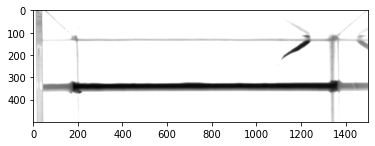

In [4]:
test_frame = np.load(os.path.join(imgspath, flist[5150]))
plt.imshow(test_frame, plt.cm.gray)
print(test_frame.shape)

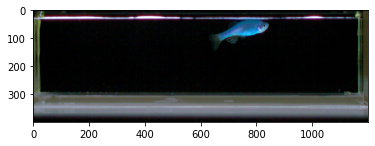

In [5]:
video = cv2.VideoWriter("output1.avi", cv2.VideoWriter_fourcc(*"MJPG"), 10, (1200,800))
for s in range(data_len):
    
    b = cv2.resize(np.flip(np.load(os.path.join(imgspath, flist[s+data_len]))), (1200,400))
    b = cv2.cvtColor(b, cv2.COLOR_GRAY2RGB)
    a = cv2.cvtColor(np.load(os.path.join(imgspath, flist[s])), cv2.COLOR_BAYER_BG2RGB)
    a = cv2.resize(a, (1200,400))
    video.write(np.concatenate((b, a), axis=0))
video.release()
plt.imshow(a)


In [6]:

cv2.imwrite("test.png", a)

True

In [ ]:
a = cv2.cvtColor(np.load(os.path.join(imgspath, flist[s])), cv2.COLOR_BAYER_BG2GRAY)
back = np.zeros(a.shape)
for s in tnum:
    a = cv2.cvtColor(np.load(os.path.join(imgspath, flist[s])), cv2.COLOR_BAYER_BG2GRAY)
    back += a
back = back/len(tnum)
back = back.astype('uint8')

In [ ]:
video = cv2.VideoWriter("output1.avi", cv2.VideoWriter_fourcc(*"MJPG"), 10, (a.shape[1], a.shape[0]), True)
kernel = np.ones((3,3), np.uint8)
for s in range(data_len):
    a = cv2.cvtColor(np.load(os.path.join(imgspath, flist[s])), cv2.COLOR_BAYER_BG2GRAY)
    diff = ((cv2.absdiff(a, back)>30)*255).astype('uint8')
    
    diff = cv2.erode(diff, kernel, iterations = 4)
    diff = cv2.dilate(diff, kernel, iterations = 6)
    a = cv2.cvtColor(np.load(os.path.join(imgspath, flist[s])), cv2.COLOR_BAYER_BG2RGB)
    video.write(cv2.bitwise_and(a, a, mask = diff)) #apply mask
    
video.release()

    
diff = cv2.dilate(diff, kernel, iterations = 3)
plt.imshow(diff)
#cv2.imwrite("test.png", diff)

In [ ]:
    labels = label(img, connectivity=2, background=0)
    group = regionprops(labels, cache=True)

# 找出ZebraPCA

In [7]:
tnum = np.random.randint(data_len,size = 1000)
a = np.load(os.path.join(imgspath, flist[s+data_len]))
background = np.zeros(a.shape)
for s in tnum:
    a = np.load(os.path.join(imgspath, flist[s+data_len]))
    background += a
background = background/len(tnum)
background = background.astype('uint8')


In [14]:
imgs = []

for s in range(data_len):
    
    img = np.load(os.path.join(imgspath, flist[s+data_len]))
    img = cv2.absdiff(img, background)
    img = np.where(img>120, 255, 0).astype('uint8')
    pos = get_pos(img)
    img = cutting_img(img, pos, 120)
    try :
        sk = NT_skeleton(img)
    except :
        print(s)
    imgs.append(img)

1514
1515
1517
1518
1519
1520
1521
1522
1523
1524
1525
1527
1529
1530
1531
1532
1533
1534
1535
1536
1537
1538
1539
1540
1541
1543
1547
1799
1800
1802
1803
1804
1806
1808
1810
1811
1813
1816
1820
1821
1833
1834
1919
1965
1966
1967
1968
1969
1970
1971
1972
2017
2019
2020
2021
2024
2059
2060
2061
2062
2064
2066
2067
2070
2071
3032
3033
3034
3035
3036
3037
3038
3039
3040
3041
3172
3173
3174
3180
3181
3199
3226
3238
3239
3241
3242
3243
3267
3269
3270
3271
3272
3273
3274
3277
3278
3280


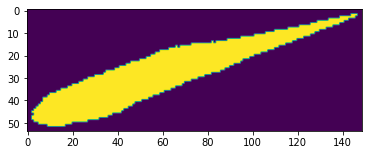

ValueError: cannot compute fingerprint of empty list

In [20]:
def NT_skeleton(img):
  
    ekernel = np.array([[0,1,0],
                      [1,0,1],
                      [0,1,0]], dtype = 'uint8')

    img = pre_img(img) 
    labels = label(img, connectivity=1, background=0)
    group = regionprops(labels, cache=True)
    
    n, index = 0, 0
    area = 0
    for com in group:
        if com.area > area:
            index = n
            area = com.area
        n += 1
    com = group[index]
    
    #the minimus box contain all points of the img
    min_row, min_col, max_row, max_col = com.bbox
    #sub = img[min_row:max_row, min_col:max_col]

    min_row = min_row -2
    min_col = min_col -2
    max_row = max_row +2
    max_col = max_col +2
    
    #sub = np.pad(sub,((2,2),(2,2)),'constant',constant_values = (0,0))
    
    #the minumus box's size
    row, col = (max_row-min_row, max_col-min_col)  
    points = com.coords - np.array([min_row, min_col]) 

    sub = np.zeros((row, col), dtype=np.uint8)
    sub[points[:,0],points[:,1]] = 255
    #cut to smallest size
    erosion = cv2.erode(sub,ekernel,iterations = 1)    
    height = cv2.distanceTransform(erosion, cv2.DIST_L2, 3)[points[:,0],points[:,1]]
    
    
    not_known = erosion>100
    is_bound = np.logical_xor(erosion, sub)

    #points

    points_ord = np.argsort(height)  

    U, count = find_U(is_bound, points[points_ord], not_known) #0.3ms
    
    result = find_cen(U,count) #1ms
    result = (result)*(erosion>100)

    point = np.nonzero(result)
    point = list(zip(point[0],point[1]))
    plt.imshow(sub)
    plt.show()
    skeleton = find_ske(result, point, sub)+np.array([min_row, min_col])
    
    return skeleton

plt.imshow(imgs[1514])
NT_skeleton(imgs[1514])

(-0.5, 240.5, 240.5, -0.5)

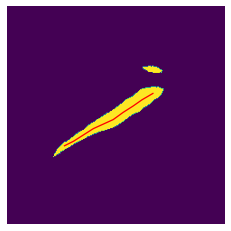

In [11]:
s = 150
sk = NT_skeleton(imgs[s])
plt.imshow(imgs[s])
plt.plot(*np.flip(sk, axis=1).T, lw=1.3, color='r')
plt.axis('off')
#plt.imshow(np.load(os.path.join(imgspath, flist[s+data_len])))

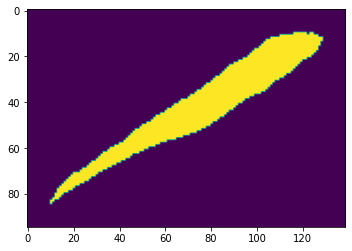

In [10]:
ekernel = np.array([[0,1,0],
                  [1,0,1],
                  [0,1,0]], dtype = 'uint8')

img = pre_img(imgs[s]) 
labels = label(img, connectivity=1, background=0)
group = regionprops(labels, cache=True)

n, index = 0, 0
area = 0
for com in group:
    if com.area > area:
        index = n
        area = com.area
    n += 1
com = group[index]

#the minimus box contain all points of the img
min_row, min_col, max_row, max_col = com.bbox
#sub = img[min_row:max_row, min_col:max_col]

pad = 10

min_row = min_row -pad
min_col = min_col -pad
max_row = max_row +pad
max_col = max_col +pad

row, col = (max_row-min_row, max_col-min_col)  
points = com.coords - np.array([min_row, min_col]) 

sub = np.zeros((row, col), dtype=np.uint8)
sub[points[:,0],points[:,1]] = 255

plt.imshow(sub)